In [1]:
#Description: 
#  This notebook uses LIME to make post-hoc explanations of classifications
#  LIME stands for local interpretable model-agnostic explanations 
#  see https://github.com/marcotcr/lime
#      https://arxiv.org/abs/1602.04938
#
#  Another alternative is to use SHAP (SHapley Additive exPlanations): https://github.com/slundberg/shap
#

# Setup

In [2]:
#imports

import numpy as np
from keras.applications import inception_v3 as inc_net

from tensorflow.keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions

import lime
from lime import lime_image

import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries


2023-06-23 18:17:05.155934: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Model and Parameters

In [3]:
# Load the inception model
model = inc_net.InceptionV3()


2023-06-23 18:17:07.602015: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-23 18:17:07.604301: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
# Set input image size used by model
image_size=(299, 299)


# Form Preprocessing Function

In [5]:
preprocess = inc_net.preprocess_input
#see https://github.com/keras-team/keras-applications/blob/master/keras_applications/inception_v3.py#L407
#which calls
#https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py#L42

# Form Inverse-processing Function

In [6]:
########################################
# inv_preprocess function
#
# Inputs [I] & Outputs [O]:
# [I] x: image that has been processed by model preprocessing 
#
# Description
#
#   Inception scales inputs between -1 and 1, so we undo that here

inv_preprocess = lambda x: x / 2 + 0.5
#inverse of https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py#L42


# Load Data To Examine

In [7]:
n=56
image_path = "/home/dm/ml_n_code/sandbox/cats_vs_dogs/data/train/Cat/" + str(n)+".jpg"


In [8]:
img_raw = image.load_img(image_path, target_size=image_size)
x = image.img_to_array(img_raw)
x = np.expand_dims(x, axis=0)
x = preprocess(x)

out = []
out.append(x)
data=np.vstack(out)

Text(0.5, 1.0, 'Original')

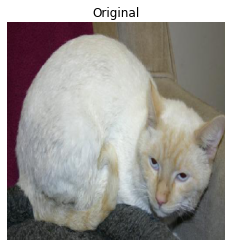

In [9]:
#check input image
plt.imshow(img_raw)
plt.axis("off")
plt.title("Original")


Text(0.5, 1.0, 'Inverse-Preprocessing Check')

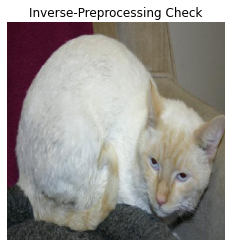

In [10]:
#spot-check inverse-preprocessing function
plt.imshow(inv_preprocess(data[0]))
plt.axis("off")
plt.title("Inverse-Preprocessing Check")


# Find Prediction(s)

In [11]:
preds = model.predict(data)
print('Predicted:')
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
for x in decode_predictions(preds)[0]:
    print(x)

1/1 [==============================] - 1s 1s/step
Predicted:
('n02124075', 'Egyptian_cat', 0.1489736)
('n02123159', 'tiger_cat', 0.07857802)
('n02123597', 'Siamese_cat', 0.04815886)
('n03223299', 'doormat', 0.042113308)
('n02123045', 'tabby', 0.04117883)


# Find Explanations

In [12]:
# Create the LIME explainer
explainer = lime_image.LimeImageExplainer()


In [13]:
# Explain the prediction
explanation = explainer.explain_instance(
    data[0].astype('double'), #pass in preprocessed data
    model.predict, 
    top_labels=5, 
    hide_color=0, 
    num_samples=1000
)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


Text(0.5, 1.0, 'Explanation')

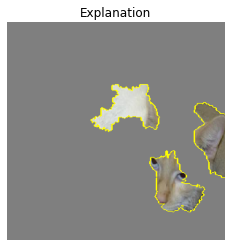

In [14]:
#see the explanation for the top class -- just show positive parts
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=True, 
    num_features=5, 
    hide_rest=True
)
plt.imshow(mark_boundaries(inv_preprocess(temp), mask))
plt.axis("off")
plt.title("Explanation")


Text(0.5, 1.0, 'Explanation Mask')

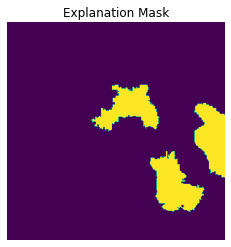

In [15]:
#show region label mask
plt.figure()
plt.imshow(mask)
plt.axis("off")
plt.title('Explanation Mask')

Text(0.5, 1.0, 'Explanation with Rest of Image')

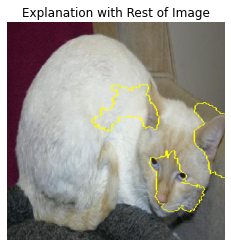

In [16]:
#see the explanation for the top class -- with the rest of the image present
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=True, 
    num_features=5, 
    hide_rest=False
)
plt.imshow(mark_boundaries(inv_preprocess(temp), mask))
plt.axis("off")
plt.title('Explanation with Rest of Image')

Text(0.5, 1.0, 'Explanation Pros (Green) and Cons (Red)')

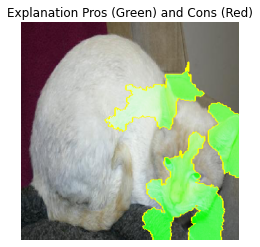

In [17]:
#see the 'pros and cons' (pros contributing to class call in green, cons in red)
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=False, 
    num_features=10, 
    hide_rest=False)
plt.imshow(mark_boundaries(inv_preprocess(temp), mask))
plt.axis("off")
plt.title('Explanation Pros (Green) and Cons (Red)')

Text(0.5, 1.0, 'Explanation Heatmap')

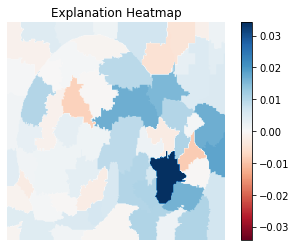

In [18]:
#explanation weights heatmap visualization

#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()
plt.axis("off")
plt.title('Explanation Heatmap')

In [19]:
explanation.top_labels[0]

285